In [1]:
import numpy as np
from scipy import fft as fft
from scipy.sparse.linalg import LinearOperator
from matplotlib import pyplot as plt
  
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200 # 200 e.g. is really fine, but slower
plt.rcParams['axes.facecolor'] = 'black'
plt.rcParams['figure.facecolor'] = 'black'
plt.rcParams['text.color'] = 'white'

class Operator(LinearOperator):
    def __init__(self, N=500, L=1):
        self.L = L
        self.N = N
        self.shape = (N,N)
        self.x = np.linspace(0, self.L, num=self.N, endpoint=False)

    
class FourierMultiplier(Operator):

    def __init__(self, transform='dct', **kwargs):
        super().__init__(**kwargs)
        self.dtype = None
        self.freqs = fft.fftfreq(self.N, d=self.L/self.N)
        self.multiplier = None ## Need to implement this on particular case
        self.transform = transform
        if self.transform == 'dct':
            self.fwd = fft.dct
            self.inv = fft.idct
            self.func = np.cos
        elif self.transform == 'dst':
            self.fwd = fft.dst
            self.inv = fft.idst
            self.func = np.sin
        elif self.transform == 'fft':
            self.fwd = np.fft.fft
            self.inv = np.fft.ifft
            self.func = lambda x: np.exp(2j*x)
            
    def eigenfunction(self, i):
        return lambda x: self.func(np.pi*self.freqs[i]*x)
        
    def eigenvector(self, i):
        v = self.eigenfunction(i)(self.x)
        return v / np.linalg.norm(v)
    
    def to_freq_domain(self, u, axis=-1):
        return self.fwd(u, axis=axis)/np.sqrt(self.N)
    
    def to_time_domain(self, u, axis=-1):
        return self.inv(u, axis=axis) * np.sqrt(self.N)
    
    def coeff2u(self, coeff):
        res = sum(coeff[i]*self.eigenfunction(i)(self.x) for i in np.where(np.abs(coeff) > 1e-5)[0])
        return res    
    
    def mult2time(self, mult):
        '''mult is assumed 2D!!!'''
        assert len(mult.shape) == 2
        # M4 = ifft(mult, axis=0)
        # M4 = ifft(M4.H, axis=0)
        M = self.to_time_domain(mult, axis=0)
        M = self.to_time_domain(M.conjugate().T, axis=0)
        return M
    
#     def _matvec(self, v):
#         return self(np.squeeze(v))
    
    def __call__(self, v, mult=None):
        if mult is None:
            mult = self.multiplier
        v_hat = self.to_freq_domain(v)
        Av_hat = v_hat * mult
        Av = self.to_time_domain(Av_hat) 
        return Av + np.mean(v)
    
#     @property
#     def matrix(self):
#         M = np.diag(self.multiplier) if len(self.multiplier.shape) == 1 else self.multiplier
#         M = self.inv(M)
#         M = M.conjugate().T
#         M = self.inv(M).conjugate().T
#         return M
        
    def __repr__(self):
        return str(self)
    
    def __str__(self):
        return 'Generic Fourier multiplier'
    
## Forward Operator
class Heat(FourierMultiplier):
    def __init__(self, time, alpha=1, **kwargs):
        super().__init__(**kwargs)
        self.alpha = alpha
        self.time = time
        self.multiplier = np.exp(-self.alpha * np.pi**2 * self.time * self.freqs**2)
          
    def __str__(self):
        return f'Heat operator alpha {alpha} time {time}'

    
class Prior(FourierMultiplier): ## Actually, negative Laplacian
    def __init__(self, gamma, **kwargs):
        assert gamma < 0
        super().__init__(**kwargs)
        multiplier = np.power(np.pi**2 * self.freqs**2, gamma)
        inv_mult = np.power(np.pi**2 * self.freqs**2, -gamma)
        ind = (multiplier < 1e-4) | (inv_mult < 1e-4) #| np.isnan(multiplier) | np.isnan(inv_mult) | (multiplier > 1e4) | (inv_mult > 1e4)
        #ind[0] = True
        #ind[-1] = True
        multiplier[ind] = 0
        self.multiplier = multiplier
        inv_mult[ind] = 0
        self.inv_mult = inv_mult
        self.gamma = gamma
        #self.kwargs = kwargs
        #self.ind = ind
        
    
    def sample(self, return_coeffs=False):
        if self.transform == 'fft':
            coeffs = np.random.randn(self.N, 2).view(np.complex128) 
            coeffs = np.squeeze(coeffs)
        else:
            coeffs = np.random.randn(self.freqs.size)
        coeffs *= self.multiplier
        coeffs[0] = 0
        
        u0 = self.coeff2u(coeffs) 
        return u0, coeffs if return_coeffs else u0
        
    def inverse(self,v):
        return self(v, mult=self.inv_mult)
#         return Laplacian(gamma=-self.gamma, N=self.N, L=self.L)
    
    def __str__(self):
        return '$(-\Delta)^{' + str(self.gamma) + '}$'
    
    @property
    def invstr(self):
        return '$(-\Delta)^{' + str(-self.gamma) + '}$'    
    

In [2]:
class PointObservation(FourierMultiplier):
    def __init__(self, meas=[], **kwargs):
        super().__init__(**kwargs)
        self.meas = np.array(meas)
        self.size = len(meas)
        self.multiplier = np.zeros((self.size, self.N), dtype=np.complex128)
        for k in range(self.N):
            self.multiplier[:,k] = self.eigenfunction(k)(self.meas)/np.sqrt(self.N)
        
    def __call__(self, v):
        vhat = self.to_freq_domain(v)
        return np.einsum('ij, j -> i', self.multiplier, vhat)
                
        
class DiagObservation(FourierMultiplier):
    def __init__(self, singular_values, random_U=False, **kwargs):
        super().__init__(**kwargs)
        singular_values = np.array(singular_values)
        assert len(singular_values.shape) == 1
        self.multiplier = np.zeros((singular_values.shape[0], self.N))
        np.fill_diagonal(self.multiplier, singular_values)
        if random_U:
            H = np.random.randn(singular_values.shape[0], singular_values.shape[0])
            Q, R = np.linalg.qr(H) # From https://stackoverflow.com/questions/38426349/how-to-create-random-orthonormal-matrix-in-python-numpy
            Q = np.vdot(Q, np.diag(np.sign(np.diag(R))))
            self.multiplier = np.dot(Q, self.multiplier)
        O = self.to_time_domain(self.multiplier)
        Ostar = O.T.conj()
        self.OstarO = np.dot(Ostar, O)

<ipython-input-3-785368a4ce68>:9: RuntimeWarning: LinearOperator subclass should implement at least one of _matvec and _matmat.
  fwd = Heat(N=N, L=L, alpha=alpha, time=time, transform=transform)
<ipython-input-3-785368a4ce68>:10: RuntimeWarning: LinearOperator subclass should implement at least one of _matvec and _matmat.
  prior = Prior(gamma=gamma, N=N, L=L, transform=transform)
<ipython-input-1-10db9c07d243>:114: RuntimeWarning: divide by zero encountered in power
  multiplier = np.power(np.pi**2 * self.freqs**2, gamma)
<ipython-input-3-785368a4ce68>:11: RuntimeWarning: LinearOperator subclass should implement at least one of _matvec and _matmat.
  obs = PointObservation(meas=[0.2356323, 0.9822345, 1.451242, 1.886632215, 2.43244, 2.89235633, 1, 1.2], L=L, N=N, transform=transform)
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home

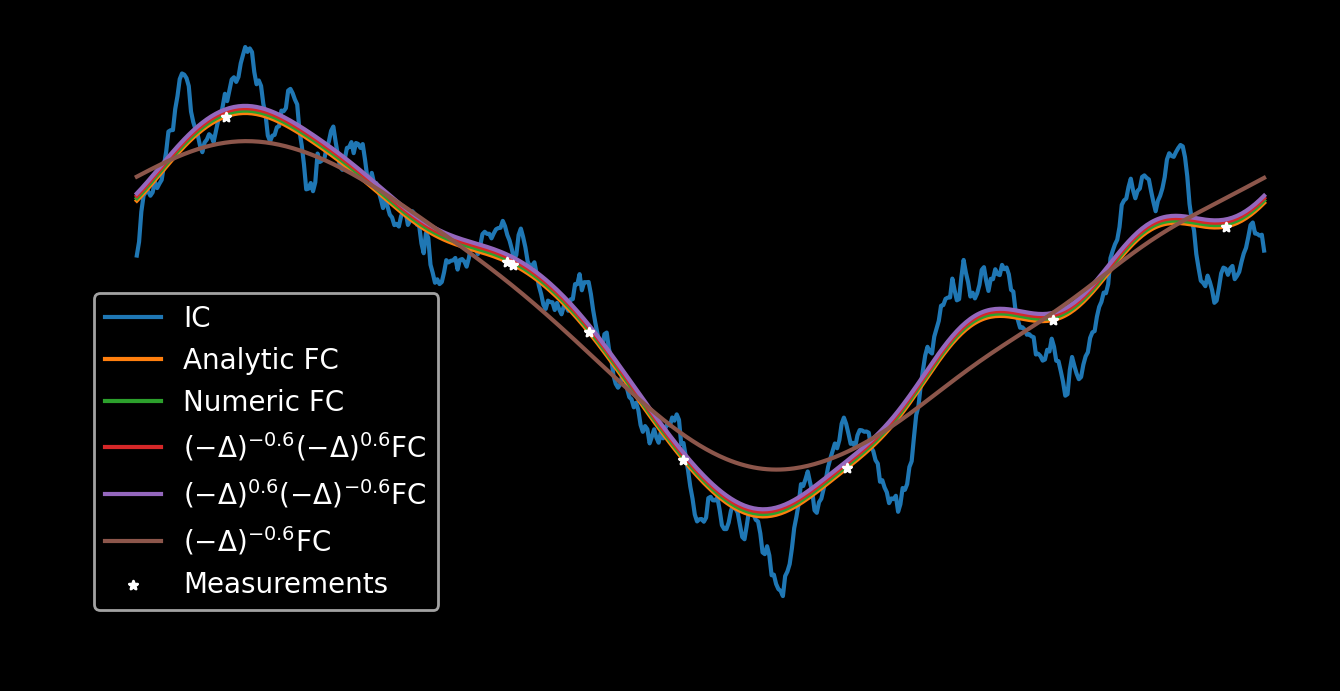

In [3]:
N = 500
L = 3
time = 5e-2
alpha = 0.6
gamma = -.6
transform = 'fft'


fwd = Heat(N=N, L=L, alpha=alpha, time=time, transform=transform)
prior = Prior(gamma=gamma, N=N, L=L, transform=transform)
obs = PointObservation(meas=[0.2356323, 0.9822345, 1.451242, 1.886632215, 2.43244, 2.89235633, 1, 1.2], L=L, N=N, transform=transform)

# IC
u0, coeffs0 = prior.sample(return_coeffs=True)

# Analytic
coeffsT = coeffs0 * fwd.multiplier
uT = prior.coeff2u(coeffsT)

# Numeric solution
uT_num = fwd(u0)

plt.plot(fwd.x, u0.real, label='IC')
plt.plot(fwd.x, uT.real, label='Analytic FC')
plt.plot(fwd.x, uT_num.real+0.025, label='Numeric FC')
plt.plot(prior.x, prior(prior.inverse(uT))+0.05, label=str(prior) + prior.invstr + 'FC')
plt.plot(prior.x, prior.inverse(prior(uT))+0.075, label=prior.invstr + str(prior) + 'FC')
plt.plot(prior.x, prior(uT), label= str(prior) + 'FC')
#plt.plot(prior.x, prior.inverse(uT), label= prior.inv_str + 'FC')
plt.scatter(obs.meas, obs(uT).real, label='Measurements', marker='*', s =10, color='w', zorder=10)

plt.legend()
#plt.close()

<ipython-input-4-f317f079644c>:44: RuntimeWarning: LinearOperator subclass should implement at least one of _matvec and _matmat.
  obs = PointObservation(meas=meas, L=L, N=N, transform=transform)
<ipython-input-4-f317f079644c>:48: RuntimeWarning: LinearOperator subclass should implement at least one of _matvec and _matmat.
  post = Posterior(data=data, fwd=fwd, obs=obs, prior=prior, sigSqr=sig**2, L=L, N=N, transform=transform)


mult2time err 0.10044612499180663


/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
<ipython-input-4-f317f079644c>:60: RuntimeWarning: LinearOperator subclass should implement at least one of _matvec and _matmat.
  obs = PointObservation(meas=meas, L=L, N=N, transform=transform)
<ipython-input-4-f317f079644c>:64: RuntimeWarning: LinearOperator subclass should implement at least one of _matvec and _matmat.
  post = Posterior(data=data, fwd=fwd, obs=obs, prior=prior, sigSqr=sig**2, L=

mult2time err 0.7977493425605071


/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


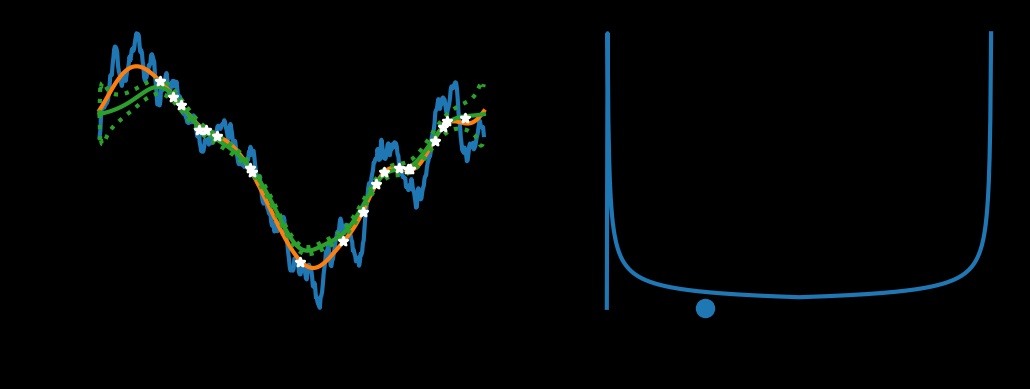

In [4]:
class Posterior(FourierMultiplier):
    ''' Based on Stuart 2.16a and 2.16b'''
    def __init__(self, data, fwd, obs, prior, sigSqr, **kwargs):
        super().__init__(**kwargs)
        O = obs.multiplier#.real
        F = fwd.multiplier#.real
        Sigma0 = prior.multiplier#.real       
        
        A = np.einsum('ij,j->ij', O, F)
        ASigma0 = np.einsum('ij, j->ij', A, Sigma0)
        
        M = np.einsum('ij, kj-> ik', ASigma0, A.conjugate())
        M = M + sigSqr * np.eye(*M.shape)

        m = np.linalg.solve(M, data)
        m = np.einsum('ji, j->i', ASigma0.conjugate(), m)
        m = self.to_time_domain(m)       
        self.m = m
        
        Sigma = np.linalg.solve(M, ASigma0)
        Sigma = np.einsum('ij, jk->ik', ASigma0.conjugate().T, Sigma)
        Sigma = np.diag(Sigma0) - Sigma
        self.Sigma = Sigma
        
        self.ptwise = np.sqrt(np.diag(self.mult2time(Sigma)))

        #print(np.linalg.matrix_rank(M), M.shape)
        
        precision = np.einsum('ji, jk->ik',A.conjugate(), A)/sigSqr + np.diag(prior.inv_mult)
        #print('precision rank and shape', np.linalg.matrix_rank(precision), precision.shape)
        #print(precision[:2,:2])
        
        mean = np.linalg.solve(precision, np.einsum('ij, j->i',A.conjugate().T, data))/sigSqr
        mean = self.to_time_domain(mean)
        #print(np.max(np.abs(mean - m)))
        #self.m = mean
        
        self.A = A
        self.O = O
        self.F = F
        

meas = np.random.uniform(0, L, 20)
obs = PointObservation(meas=meas, L=L, N=N, transform=transform)
      
sig = 0.05
data = obs(uT) + np.random.normal(scale=sig, size=obs.size)
post = Posterior(data=data, fwd=fwd, obs=obs, prior=prior, sigSqr=sig**2, L=L, N=N, transform=transform)
     
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(6,2))
ax[0].plot(fwd.x, u0.real, label='IC')
ax[0].plot(fwd.x, uT.real, label='FC')
ax[0].scatter(obs.meas, data.real, label='Measurements', marker='*', s=10, color='w', zorder=10)
line, = ax[0].plot(post.x, post.m, label='Posterior mean')
ax[0].plot(post.x, post.m + 2*post.ptwise, color=line.get_color(), label='Posterior std', linestyle=':')
ax[0].plot(post.x, post.m - 2*post.ptwise, color=line.get_color(), linestyle=':')
#ax[0].legend()

meas = np.random.uniform(0, L, 1)
obs = PointObservation(meas=meas, L=L, N=N, transform=transform)
      
sig = 0.1
data = obs(uT) + np.random.normal(scale=sig, size=obs.size)
post = Posterior(data=data, fwd=fwd, obs=obs, prior=prior, sigSqr=sig**2, L=L, N=N, transform=transform)

ax[1].plot(post.x, post.ptwise,label='posterior STD')
ax[1].scatter(obs.meas,np.zeros(obs.size), label='measurements')


In [5]:
n = 6
singular_values = np.random.randn(n)**2
#singular_values[1] = 0
obs = DiagObservation(singular_values=singular_values,
                      N=500, 
                      random_U=True,
                      transform='dct')
D, P = np.linalg.eig(obs.OstarO)
P = np.einsum('ij, j -> ij', P, np.sign(P[0,:]))
fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(10,7))
for i in range(n):
    ax[0].plot(obs.x, P[:,i].real, label=i, color='r')
    ax[1].plot(obs.x, P[:,i].real, label=i, color='r')
    ax[2].plot(obs.x, obs.eigenvector(i), label=f'True {i}', color='r')
ax[1].plot(obs.x, P[:,i+1], label='$n+1$', color='w')

for i in range(n):
    ax[2].plot(obs.x, P[:,i].real, color='g')


/
# for axi in ax:
#     axi.legend(bbox_to_anchor=(1.05, 1), loc='upper left',
#              ncol=1, fancybox=True, shadow=True)


OstarO = "$\mathcal{O}^{*}\mathcal{O}$"
ax[0].set_title(f"First $n={n}$ eigenvectors of a diagonalizable " + OstarO)
ax[1].set_title(f"First $n+1={n+1}$ eigenvectors of the same "  +OstarO)
ax[2].set_title(f"First $n={n}$ modes of {obs.transform}")


ind = np.where(np.abs(D) > 1e-9)[0]
ax[3].plot(np.arange(n), D[:n], label='$\mathbf{e}_i$')
ax[3].plot(np.arange(n), np.zeros(n), label='y=0')
ax[3].set_title(f"Nonzero eigenvalues: {ind}")

plt.tight_layout()
plt.close()

<ipython-input-5-5a5b73f15aa3>:4: RuntimeWarning: LinearOperator subclass should implement at least one of _matvec and _matmat.
  obs = DiagObservation(singular_values=singular_values,
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/yair/.local/lib/python3.8/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


(64,)
(64,)
mult2time err 6.7094839058355084e-12


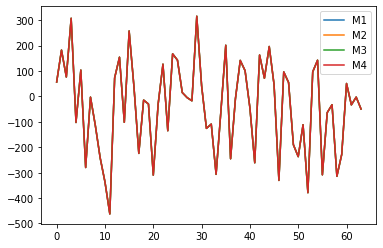

In [21]:
import numpy as np
from scipy.linalg import dft
from matplotlib import pyplot as plt
N = 64
DFT = np.matrix(dft(n=N, scale='sqrtn'))

vec = np.random.normal(size=2*N).view(np.complex128)
mult = np.random.normal(size=2*N**2).view(np.complex128).reshape(N,N)
mult = np.einsum('ij, kj->ik', mult, mult.conjugate()) + np.eye(N)
mult = np.matrix(mult)
err = np.max(np.abs(mult - mult.conjugate().T))
assert err == 0

def fft(x, axis=-1):
    x = np.array(x)
    ret = np.fft.fft(x, axis=axis)/np.sqrt(N)
    if len(ret.shape) == 2:
        ret = np.matrix(ret)
    return ret

def ifft(x, axis=-1):
    x = np.array(x)
    ret = np.fft.ifft(x, axis=axis)*np.sqrt(N)
    if len(ret.shape) == 2:
        ret = np.matrix(ret)
    return ret
 


err1 = np.linalg.norm(vec) - np.linalg.norm( fft(vec)) 
err2 = np.linalg.norm(vec) - np.linalg.norm(ifft(vec))
err3 = np.linalg.norm(vec-fft(ifft(vec)))
err4 = np.linalg.norm(vec-ifft(fft(vec)))
assert err1 < 1e-12, err1
assert err2 < 1e-12, err2
assert err3 < 1e-12, err3
assert err4 < 1e-12, err4
      
# Fast    
M1 = np.ravel(ifft(mult@fft(vec)))
print(M1.shape)

# Straightforward
M2 = DFT.H @ mult @ DFT @ vec
M2 = np.ravel(M2)
print(M2.shape)

M3 = np.einsum('ij, jk, kl->il', DFT.H, mult, DFT)
M3 = M3 @ vec

M4 = ifft(mult, axis=0)
M4 = ifft(M4.H, axis=0)
M4 = M4 @ vec
M4 = np.ravel(M4)


print('mult2time err', np.max(np.abs(M1-M2)))
plt.plot(M1.real, label='M1')
plt.plot(M2.real, label='M2')
plt.plot(M3.real, label='M3')
plt.plot(M4.real, label='M4')

plt.legend()


In [9]:
(fft(mult, axis=0)- (DFT @ mult)).real
# print(np.max(np.abs(ifft(dft(n=N, scale='sqrtn')) - np.eye(N))))
# print(np.max(np.abs(fft(np.eye(N)) - dft(n=N, scale='sqrtn'))))

matrix([[-2.66453526e-15,  7.10542736e-15, -1.42108547e-14, ...,
         -3.55271368e-15,  1.06581410e-14,  3.55271368e-15],
        [ 1.42108547e-14,  0.00000000e+00, -3.55271368e-14, ...,
         -4.44089210e-14, -4.08562073e-14, -5.32907052e-14],
        [ 7.10542736e-15, -3.55271368e-15,  1.24344979e-14, ...,
          1.50990331e-14,  1.95399252e-14,  3.19744231e-14],
        ...,
        [ 2.30926389e-14, -2.84217094e-14,  1.28785871e-14, ...,
         -9.59232693e-14, -7.46069873e-14, -1.56319402e-13],
        [-9.23705556e-14, -1.77635684e-15,  1.93622895e-13, ...,
         -3.19744231e-13, -7.10542736e-15, -1.84741111e-13],
        [ 3.10862447e-15,  3.55271368e-15,  6.17284002e-14, ...,
         -1.10134124e-13, -4.26325641e-14, -3.19744231e-14]])

(1, 64)

In [9]:
(PDP*)**

SyntaxError: invalid syntax (<ipython-input-9-fb846ccea87f>, line 1)

In [ ]:
PD

In [ ]:
fwd.transform

In [ ]:
72*1000**4 / kutsh * 0.2 / 4

In [ ]:
2**25 / 1000 /1000